In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json
import folium
import branca.colormap as cm
import seaborn as sns

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

The notebook is organized in 4 sections: (Delov kje go napisheme na kraj)
1. GDELT dataset - Description and visualization of the features in the GDELT dataset that will be used in the project.
2. Wikipedia (elections) dataset - Description of the web scraping process and the obtained dataset.
3. Results - Preliminary results and insights concerning the proposed research questions.
4. Plan - Explanation about the adjustments to the initial plan and directions for the upcoming work. 

# 1. GDELT dataset

For this project, we are using the proposed GDELT dataset containing events from every country in the World starting from 2015 and ending in 2017. Since we are observing only the countries which are members of the EU/EEA, we have filtered the original dataset to obtain only the events in which a EU/EEA member country is involved. We consider a country to be involved in an event if any of the actors are from the that country, or the event itself took place in the that country. In order to achieve that, we use a python script (presented in the project repository), that uses the country codes to filter only the events that are relevant to our analysis and save the obtained dataset in parquet format.

In [2]:
# Load the filtered dataframe
dataframe = spark.read.parquet("../blagojce/data/data_frame.parquet")

In [3]:
# Show the schema of the dataset
dataframe.printSchema()

root
 |-- GLOBALEVENTID: long (nullable = true)
 |-- Day_DATE: string (nullable = true)
 |-- MonthYear_Date: string (nullable = true)
 |-- Year_Date: string (nullable = true)
 |-- FractionDate: float (nullable = true)
 |-- Actor1Code: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1CountryCode: string (nullable = true)
 |-- Actor1KnownGroupCode: string (nullable = true)
 |-- Actor1EthnicCode: string (nullable = true)
 |-- Actor1Religion1Code: string (nullable = true)
 |-- Actor1Religion2Code: string (nullable = true)
 |-- Actor1Type1Code: string (nullable = true)
 |-- Actor1Type2Code: string (nullable = true)
 |-- Actor1Type3Code: string (nullable = true)
 |-- Actor2Code: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2CountryCode: string (nullable = true)
 |-- Actor2KnownGroupCode: string (nullable = true)
 |-- Actor2EthnicCode: string (nullable = true)
 |-- Actor2Religion1Code: string (nullable = true)
 |-- Actor2Religion2Co

From the dataframe schema, we observe that there is a large number of features which are exhaustively described in the official [documentation](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf) of the GDELT dataset. Each entry (row) in the dataset represents an action (event) performed by Actor1 upon Actor2 and the rest of the features provide additional information about the nature of the action (quantified by several parameters), date, location and the actors involved. In this section, we describe the most relevant features for our analysis, as well as visualize and interpret their distributions.   

In [4]:
# Number of actions in the dataset
dataframe.count()

31437541

We observe that there is a small number of events with dates that are outside of our range of interest (2014-2017). After analyzing these events, we conclude that their appearance is due to a mistake in the saving of the date,so we decide to drop them.

In [5]:
# Relevant years
years=['2014','2015','2016','2017']
# Number of wrong entries
dataframe.filter(dataframe["Year_Date"].isin(years)==False).count()

5116

In [6]:
# Drop wrong entries
dataframe = dataframe.filter(dataframe["Year_Date"].isin(years))

### Actors

The GDELT dataset represents events in the form of actions performed by Actor1 on Actor2. To identify the actors, GDELT uses the hierarchical CAMEO code to group actors based on several layers of diversification. Actor codes are composed of a series of three-letter groups, each corresponding to one layer in the hierarchy. For instance, the highest layer is the separation between International actors and actors belonging to a specific country. Using this approach, actors are grouped from the least specific denominator (international or country-specific) to the most specific one (organization code). It is important to mention that not all parts of the hierarcy have to be present but the relative ordering has to be respected. The tree structure of the CAMEO coding is explained on page 90 of the [CAMEO manual](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf). 

Let us first explore the number of unique actors in our dataset.

In [7]:
# Number of unique Actors
actor1 = dataframe.groupBy("Actor1Code").count()
actor2 = dataframe.groupBy("Actor2Code").count()
actor1_pd = actor1.toPandas().dropna()
actor2_pd = actor2.toPandas().dropna()
df1 = actor1_pd.set_index(['Actor1Code'])
df2 = actor2_pd.set_index(['Actor2Code'])
unique_actors = df1.add(df2, fill_value=0)
unique_actors.count()

count    12410
dtype: int64

We observe that there are 12410 unique actors in our dataset. We have decided to observe the 'Actor1Code' feature because it represents the complete raw CAMEO code for the Actor1 (includes geographic, class, ethnic, religious, and type classes), unlike the other features that contain only partial information (ex. Actor1Geo_CountryCode) and can have a 'None' value if the country of the actor cannot be specified. One such example is shown below, where the Actor1 has Actor1Code='GOV' and Actor1CountryCode='None'. This means that, according to the CAMEO code, Actor1 represents a Government (the executive, governing parties, coalitions partners etc.), but the country cannot be specified. If the country was specified, then the country code would have preceded the 'GOV' in the 'Actor1Code' (if the country was France, the 'Actor1Code' would be 'FRAGOV'). The same arguments hold for the usage of the 'Actor2Code' feature.

In [8]:
dataframe.filter(dataframe['Actor1Code'] == 'GOV').take(1)

[Row(GLOBALEVENTID=460104138, Day_DATE='20140823', MonthYear_Date='201408', Year_Date='2014', FractionDate=2014.638427734375, Actor1Code='GOV', Actor1Name='PRESIDENT', Actor1CountryCode=None, Actor1KnownGroupCode=None, Actor1EthnicCode=None, Actor1Religion1Code=None, Actor1Religion2Code=None, Actor1Type1Code='GOV', Actor1Type2Code=None, Actor1Type3Code=None, Actor2Code='FRA', Actor2Name='FRANCE', Actor2CountryCode='FRA', Actor2KnownGroupCode=None, Actor2EthnicCode=None, Actor2Religion1Code=None, Actor2Religion2Code=None, Actor2Type1Code=None, Actor2Type2Code=None, Actor2Type3Code=None, IsRootEvent=1, EventCode='040', EventBaseCode='040', EventRootCode='04', QuadClass=1, GoldsteinScale=1.0, NumMentions=8, NumSources=1, NumArticles=8, AvgTone=0.6134969592094421, Actor1Geo_Type=1, Actor1Geo_FullName='Chad', Actor1Geo_CountryCode='CD', Actor1Geo_ADM1Code='CD', Actor1Geo_ADM2Code=None, Actor1Geo_Lat=15.0, Actor1Geo_Long=19.0, Actor1Geo_FeatureID='CD', Actor2Geo_Type=1, Actor2Geo_FullName='F

Next, we want to explore which actors are involved in most events in our dataset.

Text(0,0.5,'Number of appearances')

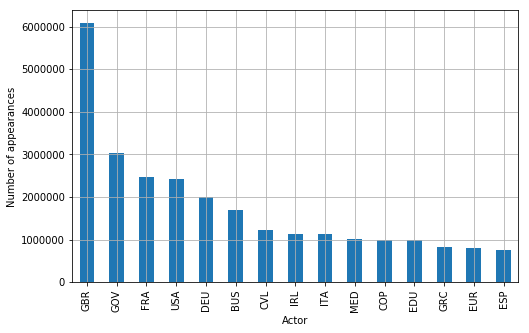

In [9]:
# Plot most involved actors
plot_actors = unique_actors.sort_values(by=['count'], ascending=False).head(15)
pl = plot_actors.plot(kind="bar",figsize=(8, 5), grid=True, legend=False)
pl.set_xlabel("Actor")
pl.set_ylabel("Number of appearances")

The plot shows the most involved actors. We can see that Great Britain is the most involved actor in the dataset. We observe that there is a large number of instances where one of the actors is a Government of a country that couldn't be specified, denoted by 'GOV' (as explained in the example above). The same can be said for 'BUS'(businessmen, companies, and enterprises), 'CVL'(civilian individuals or groups), 'COP'(police forces) and 'EDU'(educators, schools, students) whose countries couldn't be specified. It is also interesting to note that USA is the fourth most occuring actor in the dataset, even though we are only interested in the European countries. This is because there are many events where one of the actors is USA, and either the other actor is from EU/EEA or the event takes place in a country from EU/EEA.

### Event types

Similar to actors, events are also separated into different groups by a hierarchical CAMEO code. The complete CAMEO code is stored in the 'EventCode' feature, which will be very useful for our analysis because it allows us to filter events by type and observe only the events relevant for our research. For instance, we can observe events with the 'EventCode' 1383, which is the type:'Threaten unconventional attack', when we analyze the impact of terrorist threats on the popularity of right wing parties in the observed countries. In this section, we analyze the event types, starting from the most general groups and proceding with the more specific.

We start the analysis of the event types by looking at the most general grouping of the events-QuadClass, which separates events into four groups (1 = Verbal Cooperation, 3 = Verbal Conflict, 2 = Material Cooperation and 4 = Material Conflict). We observe that the vast majority of events are Verbal Cooperation, which is expected since we are observing countries in the European Union where cooperation is very common. However, it is interesting to see that the number of material conflict events is similar to material cooperation and vebral conflict, which is probably due to the involvement of EU countries in conflicts around the World.

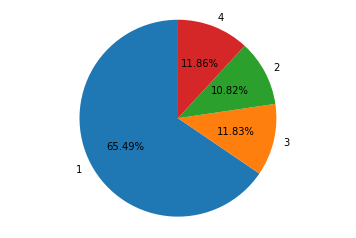

In [10]:
# Number of events of each type
quadClass = dataframe.groupBy("QuadClass").count()

# Pandas dataframe used for the plot
quadClass_pd = quadClass.toPandas()
labels = quadClass_pd['QuadClass']
sizes = quadClass_pd['count']

# Plot a pie chart of the event types
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The hierarchichal CAMEO code makes it it possible to aggregate events at various resolutions of specificity by storing different parts of the CAMEO code in different features. For instance, the event with the full CAMEO code: '0251' ('Appeal for easing of administrative sanctions') will have the value '0251' in the feature 'EventCode' and the value '02' ('Appeal') in the 'EventRootCode' feature. 

First, we analyze the more general groups by observing the most frequent values in the feature 'EventRootCode'. We observe that some event types are more prevalent than others, especially the '04'- 'Consult' events (make a visit, host a visit,engage in negotiation) which confims the findings shown in the pie chart above. We can see that the codes starting with '0' are dominant and they represent mostly cooperative event types such as diplomatic cooperation, material cooperation etc. In our analysis, an event type of interest will be '02'-Appeal, where the subgroup '024'-'Appeal for political reform', might give an insight in the political dynamics of a country. There is also a notable number of events that represent conflicts, such as '11'-'disapprove', '19'-'fight' and '17'-'coerce'.

Text(0,0.5,'Number of events')

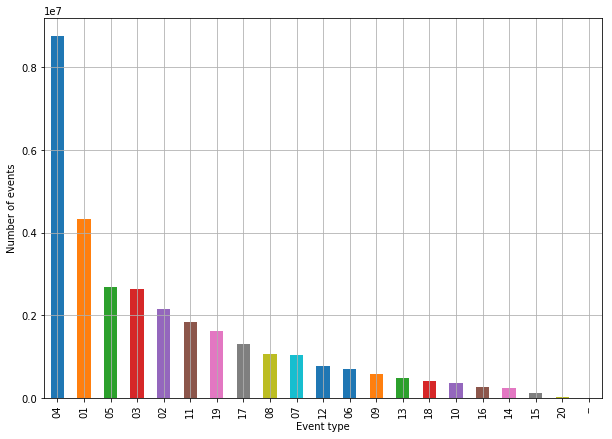

In [11]:
# Number of events for each Root Code
eventType_pd = dataframe.groupBy("EventRootCode").count().toPandas().sort_values(by=['count'],ascending=False)
# Plot the numbers of events for each Root Code
pl = eventType_pd.plot(kind="bar", x="EventRootCode", y="count", figsize=(10, 7), grid=True, legend=False)
pl.set_xlabel("Event type")
pl.set_ylabel("Number of events")

In this part, we observe the most specific separation of the events, given by the full CAMEO code which is stored in the 'EventCode' feature. We can see that there are 256 different types of events in the dataset. Furthermore, we observe that the most frequent event types are '042: Make a visit' and '043: Host a visit', as well as '010: Make statement' and '040: Make an appeal or request'. A notable observation is the high number (over 1 milion) events of type: '190: Use conventional military force', as well as event type: '173: Arrest, detain, or charge with legal action' and '111: Criticize or denounce'. These are all event types that will be of great interest when analyzing the difference between countries with populist and centralist governments. 

In [12]:
# Number of events for each full CAMEO code
CAMEO_pd = dataframe.groupBy("EventCode").count().toPandas().sort_values(by=['count'],ascending=False)
CAMEO_pd.count()

EventCode    256
count        256
dtype: int64

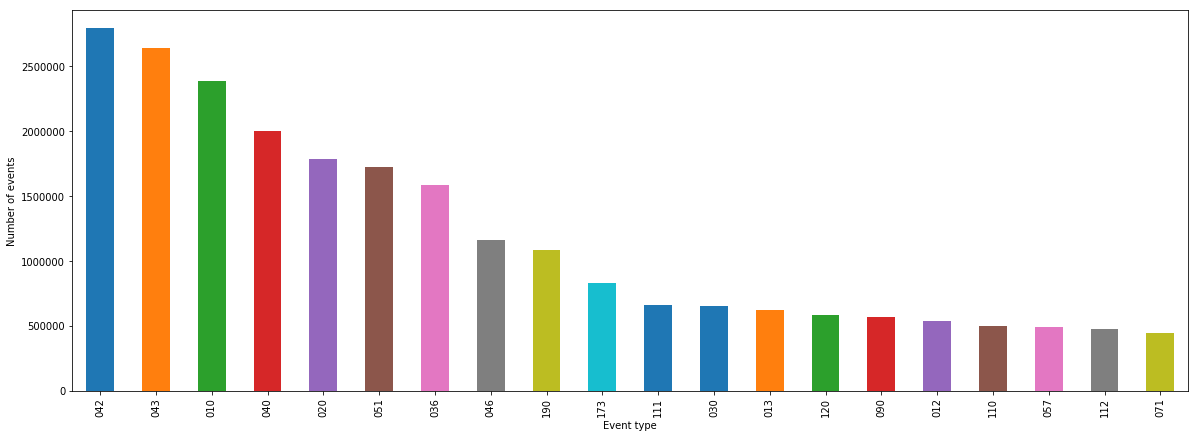

In [13]:
# Take the 20 most frequent CAMEO codes 
plot_CAMEO = CAMEO_pd.head(20)
# Plot most frequent CAMEO codes
ax = plot_CAMEO.plot(kind="bar", x="EventCode", y="count", figsize=(20, 7), grid=False, legend=False)
ax.set_xlabel("Event type")
ax.set_ylabel("Number of events")
plt.show()

### Golstein scale

Each CAMEO event code is assigned a numeric score from -10 to +10 called the Golstein scale that captures the theoretical potential impact that type of event will have on the stability of a country. For instance, a Goldstein score of -10 would be given to an event of the type: '223  Military attack; clash; assault', while a +10 would be given to an event type: '072  Extend military assistance'. This is a very useful quantification of the relationship between two entities and can be used to evaluate the different styles of governing of governments with different ideologies. 

In order to observe the distribution of the Goldstein values, we plot a histogram with the Goldstein value of each event. We observe that the number of events with positive Golstein values is larger than negative Golstein score events, meaning that there is a larger number of events of cooperation compared to events of conflict. We can also see that the majority of events is centered around the small values, meaning that most of the events have a moderate impact on the political stability of the country. A notable observation is the large number of events with a Golstein value of -10, which represent events of military conflict.

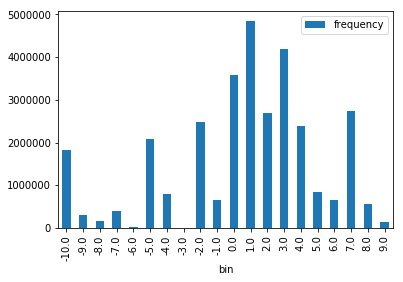

In [14]:
# Compute the histogram
gold_histogram = dataframe.select('GoldsteinScale').rdd.flatMap(lambda x: x).histogram(20)

# Load the computed histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gold_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

### Years

The provided dataset contains events from the years 2015-2017. By plotting the number of events for each year, we observe that there largest number of events in the dataset happened in 2016. There are 125519 events from 2014, which represent events that happened at the end of 2014, but were reported at the beginning of 2015. The smaller number of events for 2017 can be explained by the fact that the data provided to us contains only extracts up to the date 23.11.2017.

Text(0,0.5,'Number of events')

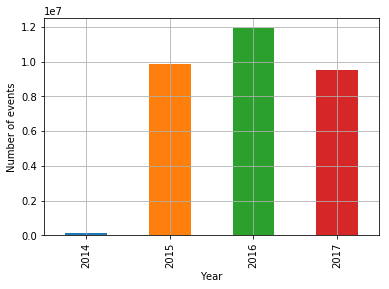

In [15]:
# Get number of events per year
eventsByYear = dataframe.groupBy("Year_Date").count().orderBy("count", ascending=False)
# Pandas dataframe used for the plot
eventsByYear_pd = eventsByYear.toPandas().sort_values(by=['Year_Date'])
# Plot the number of events for each year
pl = eventsByYear_pd.plot(kind="bar", x="Year_Date", y="count", figsize=(6, 4), grid=True, legend=False)
pl.set_xlabel("Year")
pl.set_ylabel("Number of events")

### Locations

The GDELT datatset contains several features containing information about the geographical location of the events. The most relevant for our analysis is the 'ActionGeo_CountryCode' that contains the FIPS10-4 code of the country where the event took place. We plot the number of events per country and obtain an expected result that the number of events is higher in countries with a larger population. It is notable that the UK has more than three times more events than the other largest countries in the EU.

Text(0,0.5,'Number of events')

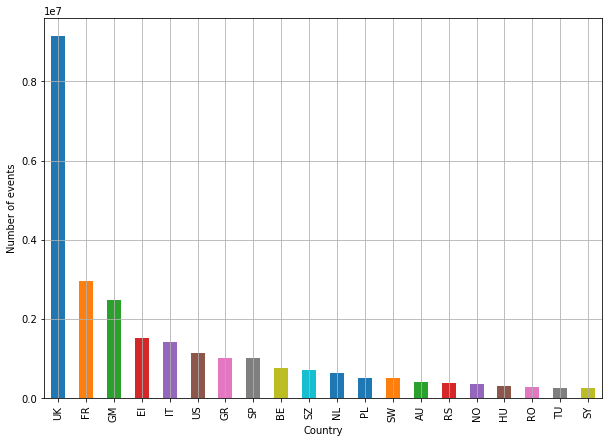

In [16]:
# Get number of events for each country
actionCountry = dataframe.groupBy("ActionGeo_CountryCode").count().orderBy("count", ascending=False)
# Pandas dataframe used for the plot 
actionCountry_pd = actionCountry.toPandas()
# Get the 20 countries with the most events
country_sliced = actionCountry_pd.iloc[0:20]
# Plot the number of events for each country
pl = country_sliced.plot(kind="bar", x="ActionGeo_CountryCode", y="count", figsize=(10, 7), grid=True, legend=False)
pl.set_xlabel("Country")
pl.set_ylabel("Number of events")

### Events between countries

In order to analyze the relationships between the countries in the EEA, we can observe the number of events between each pair of countries. We achieve this by filtering the datasat by the features 'Actor1Geo_CountryCode' and 'Actor2Geo_CountryCode' so that both countries involved in the event are members of the EEA.

In [17]:
# Countries in the EEA
fips_codes = ['AU','BE','BU','HR','CY','EZ','DK','EN','FI','FR','GM','GR','HU','EI','IT','LG','LH','LU','MT','NL','PL','PO','RO','LO','SI','SP','SW','UK','NO','LS','IC','SZ']
fips_codes_broadcast = sc.broadcast(fips_codes)

In [18]:
# Get only events between EEA countries 
pairs = dataframe.filter((dataframe["Actor1Geo_CountryCode"].isin(fips_codes_broadcast.value)) &
                              (dataframe["Actor2Geo_CountryCode"].isin(fips_codes_broadcast.value))).groupBy(['Actor1Geo_CountryCode', 'Actor2Geo_CountryCode']).count()

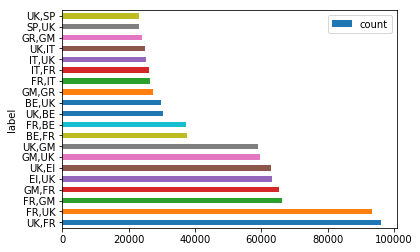

In [19]:
# Dataframe used for the plot
pairs_pd = pairs.toPandas()
# Exclude internal events (within the same country)
pairs_pd = pairs_pd[pairs_pd['Actor1Geo_CountryCode']!=pairs_pd['Actor2Geo_CountryCode']].sort_values('count', ascending=False)
# Labels of country pairs for the plot
pairs_pd['label'] = pairs_pd["Actor1Geo_CountryCode"].map(str) + ',' + pairs_pd["Actor2Geo_CountryCode"].map(str)
# Plot the 20 most frequent pairs
pairs_pd.head(20).plot.barh(x='label', y='count')

### Average Tone (Germany)

Every event in the dataset has an 'Average Tone' feature which presents the average “tone” of all documents containing one or more mentions of this event. It is a quantification of the nature of the event (-100 denotes an extremely negative event and +100 an extremely positive one). This is very useful for our analysis because it gives us an insight into the relationships between countries. Furthermore, we can analyze a country's attitude towards specific topics by observing the tone of the events covering that topic that the country has been involved in. To illustrate how we can use this feature, we analyze the average tone of the events between Germany and every other EEA country.  

In [20]:
# Actions performed by Germany to EEA countries
dataframe_de = dataframe.filter((dataframe['Actor1Geo_CountryCode'] == 'GM') & dataframe["Actor2Geo_CountryCode"].isin(fips_codes_broadcast.value))

In [21]:
# Number of actions performed by Germany to EEA countries
dataframe_de.count()

1342717

In [22]:
# Average tone between Germany and every other EEA country
avg_tone_de = dataframe_de.groupBy('Actor2Geo_CountryCode').mean('AvgTone').orderBy('avg(AvgTone)')

Text(0,0.5,'Average Tone')

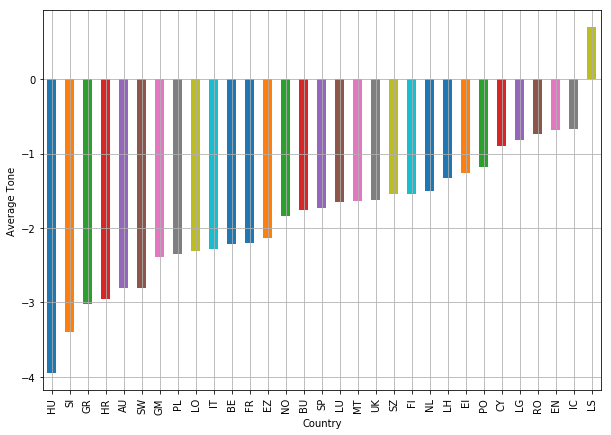

In [23]:
# Pandas dataframe used for the plot
avg_tone_de_pd = avg_tone_de.toPandas()
# Plot the average tone between Germany and every other EEA country
plot = avg_tone_de_pd.plot(kind="bar", x="Actor2Geo_CountryCode", y="avg(AvgTone)", figsize=(10, 7), grid=True, legend=False)
plot.set_xlabel("Country")
plot.set_ylabel("Average Tone")

It is interesting to see that the only country Germany has a positive average tone with, is Liechtenstein. For every other country the average tone is negative, with the lowest being for Hungary, Slovenia and Greece respectively. In the following part we compare the average tone for Germany for the years 2015 and 2017, in order to see how events in those years affect the average tone.

In [24]:
# Actions performed by Germany to EEA countries in 2015
dataframe_de_15 = dataframe_de.filter(dataframe_de["Year_Date"] == "2015")
# Actions performed by Germany to EEA countries in 2017
dataframe_de_17 = dataframe_de.filter(dataframe_de["Year_Date"] == "2017")

In [25]:
# Average tone between Germany and every other EEA country in 2015
avg_tone_de_15 = dataframe_de_15.groupBy('Actor2Geo_CountryCode').mean('AvgTone').orderBy('avg(AvgTone)')
# Average tone between Germany and every other EEA country in 2017
avg_tone_de_17 = dataframe_de_17.groupBy('Actor2Geo_CountryCode').mean('AvgTone').orderBy('avg(AvgTone)')

In [26]:
# Convert to Pandas dataframe for easier manipulation
avg_tone_de_pd_15 = avg_tone_de_15.toPandas()
avg_tone_de_pd_17 = avg_tone_de_17.toPandas()

In [27]:
# Merge dataframes for a single plot
avg_tone_de_combined = avg_tone_de_pd_15.merge(avg_tone_de_pd_17,how='inner',left_on='Actor2Geo_CountryCode',right_on='Actor2Geo_CountryCode') 
# Rename the columns
avg_tone_de_combined = avg_tone_de_combined.rename(columns = {'avg(AvgTone)_x':'Avg Tone 2015','avg(AvgTone)_y':'Avg Tone 2017'})

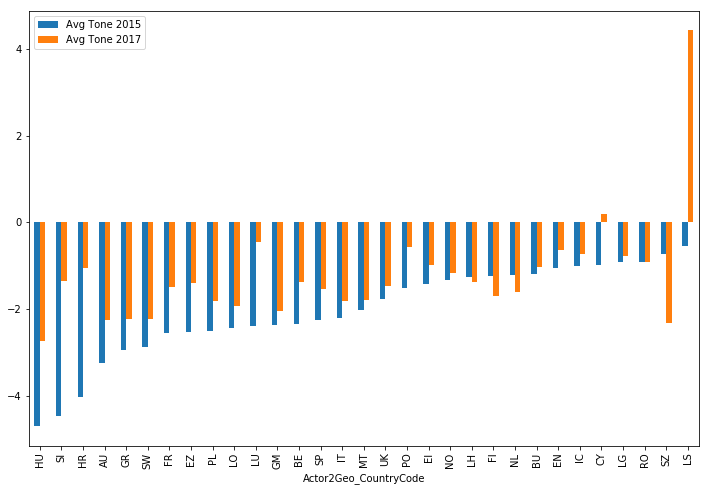

In [28]:
# Plot the comparisson between the avregare tone in 2015 and 2017
avg_tone_de_combined.plot(kind="bar", x='Actor2Geo_CountryCode', y=["Avg Tone 2015", "Avg Tone 2017"], figsize=(12,8))

We can observe from the plot that the average tone has positively increased for all countries execpt for Finland, the Netherlands and Switzerland. It is also notable that there is a large increase for Hungary, Slovenia, Croatia and Luxembourg. In addition, the average tone has is positive for Cyprus and Liechtenstein in 2017, despite beaing negative in 2015. This example illustrates how we can evaluate a government's stance on specific topics or relationships with other countries and more importantly, how the attitude of that government changes. This would allow us to draw conclusions on the differences between governments led by left leaning and right leaning parties. 

# 2. World indicators

In order to analyze the causes and effects of the rise of populism we will use some of the indicators of the <a href="https://data.worldbank.org/indicator/">World Development Indicators</a> dataset. Specifically, we are currently working with <a href="https://data.worldbank.org/indicator/SM.POP.REFG?fbclid=IwAR3zh3W9eXYD8s09Th_CwKK4Uh-TtmTBOEpPOuJh-RYh3tfVyMEWbXfe_Zo">Refugee population by country or territory of asylum</a>. However, we might use some additional indicators for the next milestones. Because these indicators have identical format, we are only showing the statistics and preprocessing steps for the number of refugees in order to reduce repetition of code. We are additionally using the the <a href="https://datacatalog.worldbank.org/political-stability-and-absence-violenceterrorism-estimate">Political Stability And Absence Of Violence/Terrorism: Estimate</a> dataset. Let us first present the format and basic statistics of these two datasets.

In [29]:
# load datasets
stab = pd.read_csv("additional_data/political_stability/political_stability.csv", header=2, sep=',')
refugees = pd.read_csv("additional_data/refugees/refugee_population.csv", header=2, sep=',')

First, we observe the number of countries and the time range covered by the two datasets. 

In [30]:
stab['Country Name'].count()

214

In [31]:
stab.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1996', '1998', '2000', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'Unnamed: 23'],
      dtype='object')

In [32]:
refugees['Country Name'].count()

264

In [33]:
refugees.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'Unnamed: 62'],
      dtype='object')

We can see that the datasets cover different number of countries and different periods. However, we are only interested in the countries from EU/EEA, and the period between 2007 and today. For this reason, we extract only the countries and years of interest from both datasets.

In [34]:
# countries and features of interest
countries = ['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark',
             'Estonia','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Lithuania',
             'Luxembourg','Malta','Netherlands','Poland','Portugal','Romania','Slovak Republic','Slovenia','Spain',
             'Sweden','United Kingdom','Norway','Iceland','Switzerland']
columns = ['Country Name','Country Code','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

In [35]:
# extract only countries of interest
stab = stab.loc[stab['Country Name'].isin(countries)]
refugees = refugees.loc[refugees['Country Name'].isin(countries)]

# reset index
stab.reset_index(inplace=True)
refugees.reset_index(inplace=True)

# extract only features of interest
stab = stab[columns]
refugees = refugees[columns]

In [36]:
# number of countries
stab['Country Name'].count()

31

In [37]:
# number of countries
refugees['Country Name'].count()

31

In [38]:
stab.columns

Index(['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [39]:
refugees.columns

Index(['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

After this preprocessing steps, we can see that the datasets are in a compatible format. In other words, they contain information for the same countries and same years. This will help us in our future analysis. If we are to use any additional indicators from World Bank, the same preprocessing steps can be applied to the indicator of interest in order to convert it to this desired format.

Let us now observe some interesting statistics about these datasets. The refugee dataset contains an information about the number of refugees who were granted asylum in each country in a specific year. We can use this dataset to observe the effects of the number of refugees on the political landscape of Europe.

First of all, we can investigate the correlation between time and number of refugees in the EU/EEA countries. 

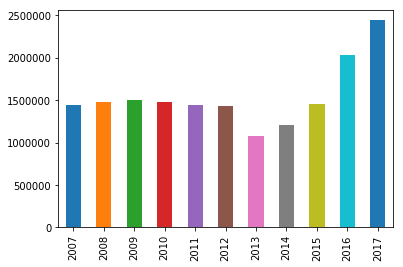

In [40]:
refugees.sum(numeric_only=True).plot(kind='bar')

We can observe that the number of refugees is steady until 2012, when it plunges and starts damatically increasing. This dramatic increase corresponds the <a href="https://en.wikipedia.org/wiki/European_migrant_crisis">European migrant crisis</a> which began in 2015. We plan to use this dataset in order to investigate whether the number of refugees in a country has an effect on the rise of populist parties. For this purpose, we can observe the evolution of number of refugees in a specific country as shown in the following plot, where we use the example of Germany for illustration purposes.

In [41]:
germany_df = pd.DataFrame()
germany_df['Year'] = refugees.columns[2:]
germany_df['Refugees'] = refugees[refugees['Country Name'] == 'Germany'][refugees.columns[2:]].squeeze().values

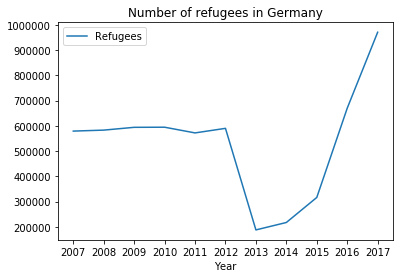

In [42]:
ax = germany_df.plot(x='Year', y='Refugees')
ax.set_xticks(range(len(germany_df["Year"].values)))
ax.set_title('Number of refugees in Germany')
_ = ax.set_xticklabels(germany_df["Year"].values)

In this case, we can observe the same trend in Germany as on the data from all countries. 

The political stability dataset contain information about the political stability of country in a specific year. Concretely, it measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5. For this dataset, it makes more sense to measure the correlation of the average political stability (instead of the sum as in the case of refugees) and time. In this dataset, we can observe two periods where the average stability decreased. The first period is during the <a href="https://en.wikipedia.org/wiki/Great_Recession">Great Recession</a>, and the second period again corresponds to the <a href="https://en.wikipedia.org/wiki/European_migrant_crisis">European migrant crisis</a>.

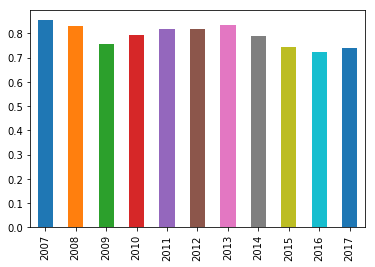

In [43]:
stab.mean(numeric_only=True).plot(kind='bar')

We plan to use this dataset in order to observe the effects of the political stability on the election results. Additionally, we can investigate the correlation between this data and some of the characteristics of the GDELT events such as the average tone or Goldstein Scale of news related to the country of interest. For this purpose, we will need to observe the evolution of political stability in a specific country over the period of interest. Once again, we plot the evolution of political stability for Germany for illustration purposes.

In [44]:
germany_df = pd.DataFrame()
germany_df['Year'] = stab.columns[2:]
germany_df['Stabillity'] = stab[stab['Country Name'] == 'Germany'][stab.columns[2:]].squeeze().values

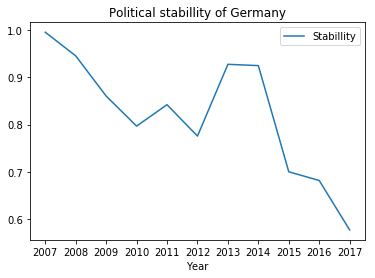

In [45]:
ax = germany_df.plot(x='Year', y='Stabillity')
ax.set_xticks(range(len(germany_df["Year"].values)))
ax.set_title('Political stabillity of Germany')
_ = ax.set_xticklabels(germany_df["Year"].values)

Once again, the data from Germany exhibits the same trend as the data on all countries, but the decrease in stability is even more severe in Germany than on the whole dataset.

# 3. Wikipedia election dataset

In this project, we are interested in the recent rise in popularity of populist countries in EU/EEA. For this purpose, we need a dataset which contains the election results from the previous two elections in each country in order to observe whether there is a change in the popularity or power of right-leaning parties. To the best of our knowledge such dataset does not exist in an explicit form. However, Wikipedia contains pages with the election results for all countries in EU/EEA. An example of such page for the most recent election in Germany can be found <a href="https://en.wikipedia.org/wiki/German_federal_election,_2017">here</a>. Using Wikipedia, we have manually created our dataset of interest. In the following section, we will present the format of the dataset, and some basic statistics. 

In [46]:
# Load and show data
parties = pd.read_csv("wikipedia_datasets/country_party_dataset.csv", index_col=0)
parties.head()

Country ISO2                               Party  Votes_last  Votes %_last  \
0  Austria   AT              Austrian Peoples Party     1595526          31.5   
1  Austria   AT  Social Democratic Party of Austria     1361746          26.9   
2  Austria   AT            Freedom Party of Austria     1316442          26.0   
3  Austria   AT              NEOS – The New Austria      268518           5.3   
4  Austria   AT              Peter Pilz List (PILZ)      223543           4.4   

   Seats_last  Seats %_last  Votes_previous  Votes %_previous  Seats_previous  \
0          62     33.879781         1125876             23.99              47   
1          52     28.415301         1258605             26.82              52   
2          51     27.868852          962313             20.51              40   
3          10      5.464481          232946              4.96               9   
4           8      4.371585               0              0.00               0   

   Seats %_previous        Political_position  
0         25.683060              centre-right  
1         28.415301               centre-left  
2         21.857923   right-wing to far-right  
3          4.918033                    centre  
4          0.000000  centre-left to left-wing

For the purpose of this dataset, we have found the Wikipedia links for the last two elections in each country of EU/EEA. From these pages, we have extracted the results of each election. We are only interested in parties which have won some seats in the national parliament because these parties have some political power and can influence the political situation in a country. We have excluded parties which have not won any seats because they are not relevant to our analysis, and their inclusion would just drastically increase the size of the dataset and decrease its clarity. Some parties have won seats in both of the last elections, but some have won seats in only one of them. We have kept all the parties which won seats in at least one of the elections in the final dataset. We have done this because parties which have won seats in the last elections for example are very relevant in our analysis, even though they have not won any seats previously. In this way, we can analyze the shift in popularity or political power in the countries more effectively. 

Additionally, we have matched each country with its political position. The information for the political position of a party can be found on the Wikipedia page of the party. An example for the German party CDU can be found <a href="https://en.wikipedia.org/wiki/Christian_Democratic_Union_of_Germany">here</a>. The political position (`centre-right` in this case) can be found on the right side under the logo. This information will be very relevant for us in order to observe the shift in popularity of parties with specific political position.

The final dataset contains the following columns:

1. _Country_: The originating country of the party
2. _ISO2_: Abbreviation of the country in ISO 2 format
3. _Party_: Name of the party
4. <i>Votes_last</i>: Votes in the last election
5. <i>Votes %_last</i>: Percentage of votes in last election
6. <i>Seats_last</i>: Seats won in the last election
7. <i>Seats %_last</i>: Percentage of seats won in last election
8. <i>Votes_previous</i>: Votes in the second to last election
9. <i>Votes %_previous</i>: Percentage of votes in second to last election
10. <i>Seats_previous</i>: Seats won in second to last election
11. <i>Seats %_previous</i>: Percentage of seats won in second to last election
12. <i>Political_position</i>: Political position of the party

For the analysis in this section, we augment the data with additional columns containing the group of political positions a party belongs to. This information is not hard coded in the original dataset in order for it to contain only information extracted from Wikipedia.

In [47]:
# Positions sorted in order of political spectrum
positions_sorted = ['far-left', 'left-wing to far-left', 'left-wing', 'centre-left to left-wing', 'centre-left', \
                    'centre to centre-left', 'centre', 'syncretic', 'big tent', 'centre to centre-right', \
                    'centre-right', 'centre-right to right-wing', 'right-wing', 'right-wing to far-right', \
                    'far-right']

For better analysis, we group the political positions in the following groups:

1. `right_wing`: all positions right of `centre`
2. `left_wing`: all positions left of `centre`
3. `far_right`: all positions right of `centre-right to right-wing` 
4. `far_left`: all positions left of `centre-left to left-wing` 
5. `centre`: central positions

After this, we augment the data with the following two columns:

1. _Right or Left_: whether the party is right or left leaning
2. _Far Right or Far Left_: whether the party is in the group `far_left`,  `far_left` or `None` if it is not in any group

In [48]:
right_wing = ['centre-right', 'right-wing to far-right', 'centre-right to right-wing', 'centre to centre-right', 'far-right', 'right-wing']
far_right = ['right-wing to far-right', 'far-right','right-wing']

left_wing = ['left-wing', 'centre-left', 'centre-left to left-wing', 'far-left', 'centre to centre-left', 'left-wing to far-left']
far_left = ['left-wing to far-left', 'far-left', 'left-wing']

center = ['centre', 'big tent', 'syncretic']

In [49]:
# Helper functions
def right_or_left(x):
    if x in right_wing:
        return "Right"
    if x in left_wing:
        return "Left"
    return "Center"

def far_right_or_far_left(x):
    if x in far_right:
        return "Far Right"
    if x in far_left:
        return "Far Left"
    return "None"

In [50]:
# Add additional columns corresponding to group
parties["Right or Left"] = parties["Political_position"].apply(right_or_left)
parties["Far Right or Far Left"] = parties["Political_position"].apply(far_right_or_far_left)

In [51]:
# Show augmented data
parties.head()

Country ISO2                               Party  Votes_last  Votes %_last  \
0  Austria   AT              Austrian Peoples Party     1595526          31.5   
1  Austria   AT  Social Democratic Party of Austria     1361746          26.9   
2  Austria   AT            Freedom Party of Austria     1316442          26.0   
3  Austria   AT              NEOS – The New Austria      268518           5.3   
4  Austria   AT              Peter Pilz List (PILZ)      223543           4.4   

   Seats_last  Seats %_last  Votes_previous  Votes %_previous  Seats_previous  \
0          62     33.879781         1125876             23.99              47   
1          52     28.415301         1258605             26.82              52   
2          51     27.868852          962313             20.51              40   
3          10      5.464481          232946              4.96               9   
4           8      4.371585               0              0.00               0   

   Seats %_previous        Political_position Right or Left  \
0         25.683060              centre-right         Right   
1         28.415301               centre-left          Left   
2         21.857923   right-wing to far-right         Right   
3          4.918033                    centre        Center   
4          0.000000  centre-left to left-wing          Left   

  Far Right or Far Left  
0                  None  
1                  None  
2             Far Right  
3                  None  
4                  None

Let us now show some basic statistics of our dataset.

## Number of parties

First, we will present the number of parties per country.

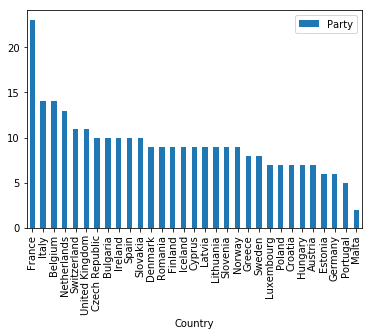

In [52]:
parties_per_country = parties.groupby("Country").count().reset_index()[["Country", "Party"]]
parties_per_country = parties_per_country.sort_values('Party', ascending=False)
parties_per_country.plot(kind="bar", x="Country")

We can observe that France has by far the biggest number of parties and Malta has the smallest number of parties. This two are the biggest outliers. We can see that most countries have around 8-10 parties. However, this information is not very relevant to our analysis because there are a lot cases where parties make coalitions or split between elections. For this reason, we are more interested in the distribution of political positions on the elections, as opposed to concrete parties.

Let us now turn our attention to the distribution of political positions in the EU/EEA parliaments. First, we will take a look at the number of parties per political position in all the countries. 

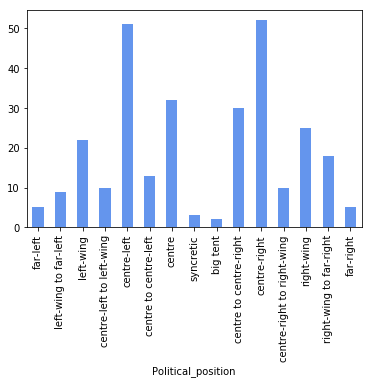

In [53]:
parties_per_position = parties.groupby("Political_position").count().reset_index()
parties_per_position = parties_per_position.set_index("Political_position").reindex(positions_sorted)
parties_per_position.plot(kind="bar", y="Party", color='cornflowerblue', legend=False)

We can see that most represented political positions are `centre-left` and `centre-right`. This shows that most of the parties in Europe are centristic with a right or left lean. However, we are alo interested whether there are more parties on the right or left political spectrum. For this purpose, we can use the additional columns created above. Let us now plot the distribution of the column `Right or Left` in order to answer this question. 

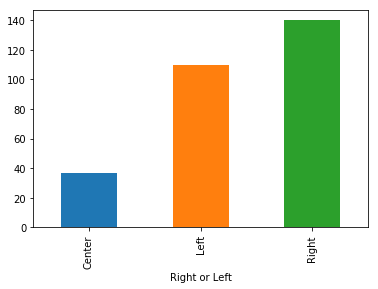

In [54]:
parties_per_position = parties.groupby("Right or Left").count().reset_index()
parties_per_position.plot(kind="bar", x="Right or Left", y="Party", legend=False)

From the plot, we can conclude that there are indeed more right-leaning parties that left-leaning ones. This is a first indicator that the parliaments of EU/EAA countries contain more conservative than liberal parties. However, this point needs to be investigated further for valid conclusions. Apart from left and right lean, we are interested whether there are more far right than far left parties. For this purpose we will investigate the distribution of the feature `Far Right or Far Left` created earlier. 

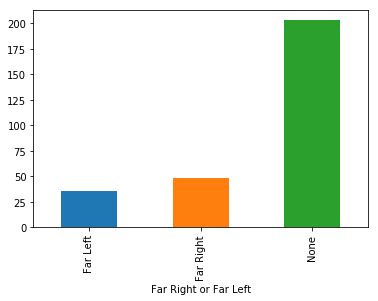

In [55]:
parties_per_position = parties.groupby("Far Right or Far Left").count().reset_index()
parties_per_position.plot(kind="bar", x="Far Right or Far Left", y="Party", legend=False)

As expected most of the parties do not belong to either of the groups. However, we again observe more far right parties than far left. This is an interesting phenomena which will present the basis for our analysis in the following milestone. 

## Number of votes - indicator for popularity

The number of parties is not the most relevant indicator of the popularity of a certain political position. This is because there could be a lot of parties with identical position but small number of votes, and one party with different position, but much bigger number of votes. For this reason, we will now turn our attention to the number of votes gained by parties from each political position as a sign of the popularity of the position. Additionally, we will observe the difference in votes between the two election in order to observe the change in popularity in the most recent elections. We are currently taking a look at the number of votes because we want to investigate the global popularity of the positions in Europe. We plan to also investigate the average popularity by repeating the same analysis with the percentage of votes, but this analysis is excluded from this notebook because it will only be a repetiton of code. 

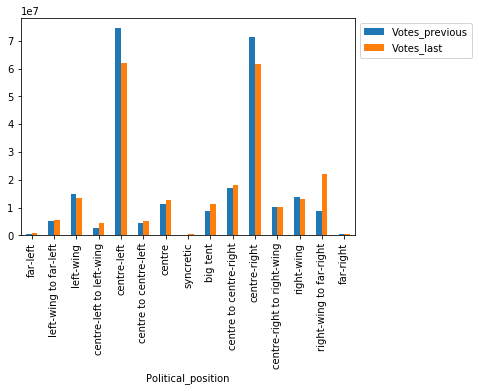

In [56]:
votes_per_position = parties.groupby("Political_position").sum().reset_index()
votes_per_position = votes_per_position.set_index("Political_position").reindex(positions_sorted)
votes_per_position.plot(kind="bar", y=["Votes_previous", "Votes_last"]).legend(bbox_to_anchor=(1, 1))

This plot shows us some very interesting phenomena. For example, even though center-right and center-left parties remain most popular in the last elections, their popularity has dramatically decreased in the last elections. On the other hand, there is a dramatic increase in the popularity of the right-wing to far-right parties. This is yet another indicator that the popularity of nationalist parties is increasing in the recent years. 

Same as before, we are also interested in the number of votes for right, left and central leaning parties. We present the number of votes for each group in the following plot.

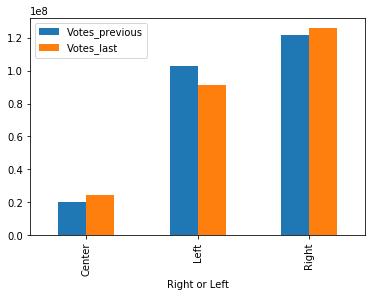

In [57]:
votes_per_position = parties.groupby("Right or Left").sum().reset_index()
votes_per_position.plot(kind="bar", x="Right or Left", y=["Votes_previous", "Votes_last"])

Yet again, we observe that right leaning parties are most popular in Europe, even when we consider the number of votes as opposed to number of parties. The plot also confirms our hypothesis that right-leaning parties are gaining popularity in the most recent elections. Central parties have also gained popularity. On the other hand, left-leaning parties have lost popularity. This indicats that the political spectrum of Europe is shifting to the right.

Let us now repeat the same analysis with regards to the far-right and far-left groups. 

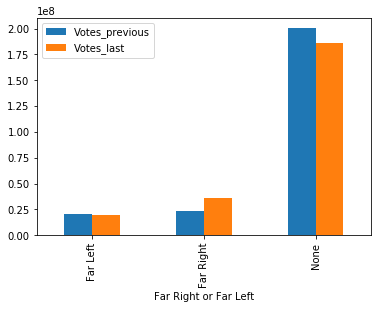

In [58]:
votes_per_position = parties.groupby("Far Right or Far Left").sum().reset_index()
votes_per_position.plot(kind="bar", x="Far Right or Far Left", y=["Votes_previous", "Votes_last"])

Once again, we observe the same phenomenon - far right parties are gaining popularity, and far left ones are losing their popularity. Additionally, the parties in between are also losing popularity. We can safely conclude that **the Right is gaining popularity**.

## Number of seats - indicator for political power

In the previous section, we have seen that the right leaning parties are gaining popularity. However, this does not mean that the right leaning parties are gaining political power. In order to investigate whether this is the case, we need to look at the percentage of seats won by parties from each political position. In this case, it makes much more sense to use the percentage of seats won as opposed to the total number because each country has a different number of seats in the parliament. We do not want to give more weight to countries with bigger parliaments. 

Let us start with comparing all the political positions.

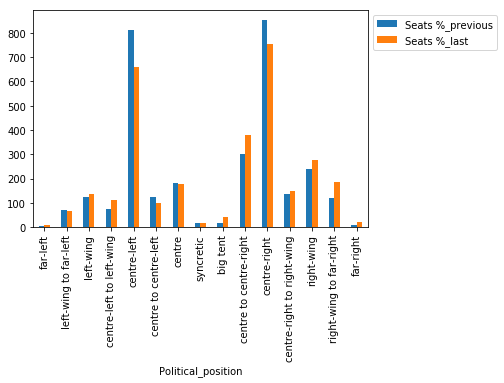

In [59]:
seats_per_position = parties.groupby("Political_position").sum().reset_index()
seats_per_position = seats_per_position.set_index("Political_position").reindex(positions_sorted)
seats_per_position.plot(kind="bar", y=["Seats %_previous", "Seats %_last"]).legend(bbox_to_anchor=(1, 1))

In the case of seats, the rise of the right is even more noticeable. First of all, we observe that centre-right and centre-left are again most powerful positions, but their power has decreased in the last elections. However, centre-right parties remain more powerful than centre-left ones. Another interesting phenomena is the fact that all positions on the right have gained seats except centre-right parties. On the other hand, several positions on the left have lost percentage of seats. 

Let us now repeat the analysis using the split on right, left and center leaning parties.

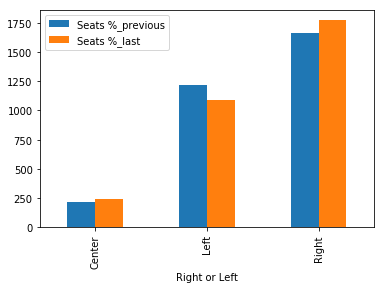

In [60]:
seats_per_position = parties.groupby("Right or Left").sum().reset_index()
seats_per_position.plot(kind="bar", x="Right or Left", y=["Seats %_previous", "Seats %_last"])

Once again, we observe the same evolution as in the number of votes. The political power is shifting to the right. 

Finally, let's observe the performance of far left and far right parties.

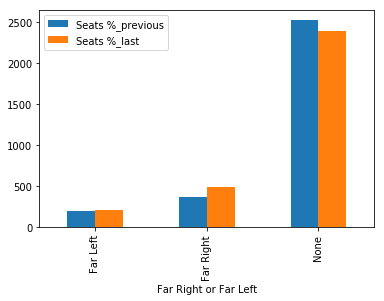

In [61]:
seats_per_position = parties.groupby("Far Right or Far Left").sum().reset_index()
seats_per_position.plot(kind="bar", x="Far Right or Far Left", y=["Seats %_previous", "Seats %_last"])

The plot indicates that far right parties are gaining power. However, in this case the far left parties have also gained some power. This is an interesting phenomena which is not in compliance with our hypothesis. We plan to investigate further the causes and interpretation of this observation in the next milestone. One implication of this plot is that the parliaments of EU/EEA are becoming more polarized. The causes and effects of this polarization will be a major focus of our final data story. Nevertheless, the gain in popularity is much bigger in the far right parties, so we can conclude that **the Right is gaining power**.

## Case of Germany

So far, we have focused on global statistics across the countries in EU/EEA. However, our dataset also allows us to perform analysis of the shift in the political spectrum of a specific country. We plan to use this information in order to find the countries with biggest shift in the political landscape and analyze the causes and effects of this shift. We can also investigate the correlation between the number of refugees and the shift in political power. Additionally, we can observe whether parties with majority of right-leaning MPs show greater stability, economic growth and other factors obtained from the `World Development Indicators` dataset. In order to illustrate the abillity to perform such analysis, we chose the example of Germany. 

In the following plot, we show the number of seats won per political position in the last two election in Germany.

In [62]:
germany = parties[parties["Country"] == "Germany"]
germany_positions_sorted = [x for x in positions_sorted if x in germany["Political_position"].values]

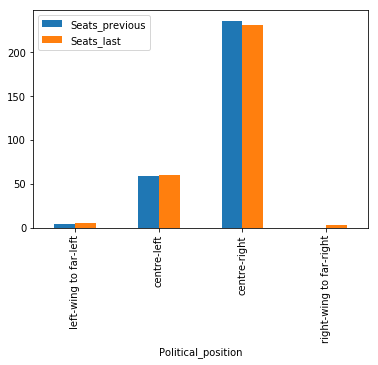

In [63]:
seats_per_position = germany.groupby("Political_position").sum().reset_index()
seats_per_position = seats_per_position.set_index("Political_position").reindex(germany_positions_sorted)
seats_per_position.plot(kind="bar", y=["Seats_previous", "Seats_last"])

We can see that centre-right parties have lost seats, and the right-wing to far-right parties have gained seats, even though they were not represented before. This fits our hypothesis that the right is gaining power. We want to investigate whether the big number of refugees in Germany was one of the leading causes for this shift.

Let us repeat the same analysis with regards to the number of votes.

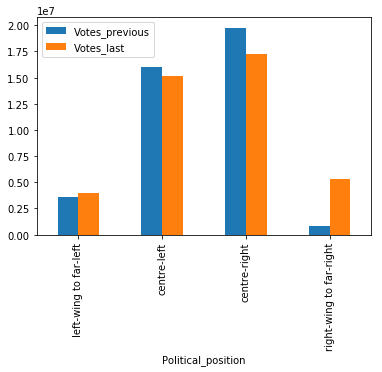

In [64]:
seats_per_position.plot(kind="bar", y=["Votes_previous", "Votes_last"])

In this plot, it is even more evident that the far right is gaining a lot of popularity in Germany. Interestingly enough, the far left is also gaining popularity, but not as significantly as the far right. Germany is becoming polarized, but what are the causes and consequenses of this phenomenon? Find out in the next episode (milestone). 

# 4. Combining the datasets

In this section we present a simple combination of the GDELT and the regufees dataset. This is to show an example on how we can combine all the previous datasets we processed, and why they are all relevant to answer our research questions.

In [65]:
# Get the number of refugees for 2014, 2015, 2016 and 2017
refugees_per_year = pd.DataFrame(refugees.sum(numeric_only=True)).reset_index()
refugees_per_year.columns = ["year", "refugees"]
refugees_per_year["year"] = pd.to_numeric(refugees_per_year["year"])
refugees_per_year = refugees_per_year[refugees_per_year["year"] >= 2014]

In [66]:
# Compute the average tone from GDELT for years 2014, 2015, 2016 and 2017
avg_tone_per_year = dataframe.groupBy("Year_Date").mean("AvgTone")
avg_tone_per_year = avg_tone_per_year.toPandas()
avg_tone_per_year["Year_Date"] = pd.to_numeric(avg_tone_per_year["Year_Date"])

In [67]:
# Combing the two data frames
merged_df = pd.merge(refugees_per_year, avg_tone_per_year, left_on="year", right_on="Year_Date")

In [68]:
# Helper function to change the width of the bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

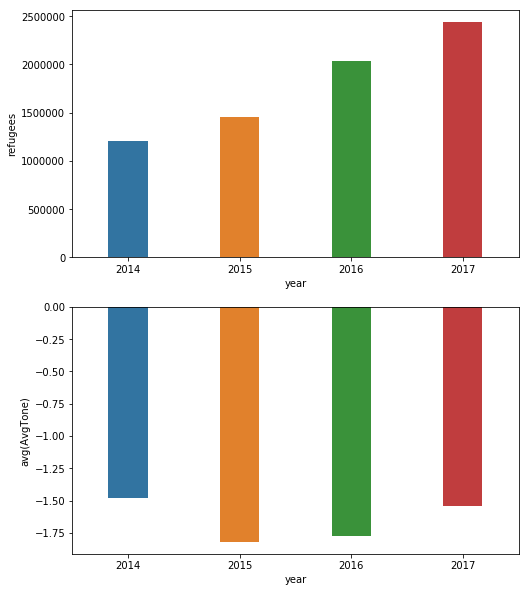

In [69]:
# Plot a simple barplot
plt.figure(1, figsize=[8, 10])
ax = plt.subplot(211)
sns.barplot(x=merged_df["year"], y=merged_df["refugees"])
change_width(ax, .35)

ax = plt.subplot(212)
sns.barplot(x=merged_df["year"], y=merged_df["avg(AvgTone)"])
change_width(ax, .35)

plt.show()

In this case we can see that the number or refugees keeps increasing, but the average tone decreases after 2015 (the year when the refugee crisis begun). Maybe the spike in Average Tone was caused by the start of the crisis and after a while the tone started decreasing as result of the measures. We plan to investigate this further in the next milestone where we will extract only the events related to refugees to have a more meaningful analysis. The previous analysis was just an example of how we can combine the datasets to answer our questions.

# 5. Map of Europe

To better represent and visualize our findings and results we plan to use Folium for drawing maps. In this part we present the Geo JSON map we got from https://github.com/leakyMirror/map-of-europe with few changes - we removed all the contires that are not in the European Union. In case there are problems with the displaying of the maps, they are saved as HTML files in the repository.

In [70]:
# Read the Geo JSON file
EU_geo_path = "additional_data/europe_map/europe.geojson"
geo_json_data = json.load(open(EU_geo_path))

In [71]:
# Plot the map of europ
m_eu = folium.Map([54, 12], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(geo_json_data).add_to(m_eu)

m_eu.save('EU_map_1.html')
m_eu

This is a simple plot showing all the countires of intereset.

In [72]:
# Read the center coordinates of the EU countires
countires_coordinates_path = "additional_data/europe_map/countries_coordinates.csv"
countires_coordinates = pd.read_csv(countires_coordinates_path)

# Create pins
for i in range(0, countires_coordinates.shape[0]):
    row = countires_coordinates.iloc[i]
    icon=folium.Icon(color='red', icon=None)
    folium.Marker([row['Longitude'], row['Latitude']], popup=row['ISO2'], icon=icon).add_to(m_eu)

m_eu.save('EU_map_2.html')
m_eu

Also, we found the geographical centers of every country and saved them in "countries_coordinates.csv" file. We use these coordinates to plot pins on the map, so we can add additional information for every country.

In [73]:
# Read the votes table
votes = pd.read_csv("wikipedia_datasets/country_party_dataset.csv", index_col=0)
# Aggregate the votes by Country and by Political position
votes_grouped = votes.groupby(["Country", "Political_position"]).sum()
votes_grouped = votes_grouped.reset_index()
# For every country find the Political position with the most votes
idx = votes_grouped.groupby(["Country"])["Votes_last"].idxmax()
votes_grouped = votes_grouped.loc[idx,]

position_sorted = ['far-left', 'left-wing to far-left', 'left-wing', 'centre-left to left-wing', 'centre-left', 'centre to centre-left', 'centre', 'centre to centre-right', 'centre-right', 'centre-right to right-wing', 'right-wing', 'right-wing to far-right', 'far-right']

In [74]:
colorscale = cm.LinearColormap(colors=['blue','ghostwhite','red'], vmin=0, vmax=12)

# Function for coloring the countires
def style_function(feature):
    pol_pos = votes_grouped[votes_grouped["Country"] == feature]["Political_position"].values[0]
    if pol_pos == 'syncretic' or pol_pos == 'big tent':
        pol_pos = "centre"
    pos = position_sorted.index(pol_pos)
    return colorscale(pos)

# Create map
m = folium.Map(
    location=[54, 12],
    tiles='cartodbpositron',
    zoom_start=4
)

# Add Geo JSON data to the map with custom colors
folium.GeoJson(geo_json_data,
    name='geojson',
    style_function=lambda feature: {
        'fillOpacity': 0.9,
        'fillColor': style_function(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1
        }
    ).add_to(m)

# Create pins
for i in range(0, countires_coordinates.shape[0]):
    row = countires_coordinates.iloc[i]
    icon=folium.Icon(color='green', icon=None)
    votes = votes_grouped[votes_grouped["Country"] == row["Country"]]["Political_position"].values[0]
    folium.Marker([row['Longitude'], row['Latitude']], popup=str(votes), icon=icon).add_to(m)

m.save('EU_map_3.html')
m

Finally, for every country we aggergate the votes from the last election by political position of the parties. We find the most popular political position per country by selection the political position with the most votes. We use this information to plot the final map where we can observe the most popular political position in the countries from the last election.